# Improving a model

First prediciton = Baseline prediction\
First model = Baseline model

### From a data perspective:
1. Could we collect more data? (Generally yes, the more the data more the accuracy of model)
2. Could we improve our data?

### From a models perspective:
1. Is there any better model we can use?
2. Could we improve our current model?

### Hyper-parameters vs parameters:
* Parameters = Model find these patterns in data
* Hyper-parameters = Settings of a model which you can adjust to (potentially) improve its ability to find patterns


### 3-ways to adjust hyper-parameters:
1. By hand
2. Randomly using RandomSearchCV
3. Exhaustively using GridSearchCV

In [47]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import numpy as np

clf = RandomForestClassifier()
clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

# 1. Tuning hyper-parameters by hand:

### We going to try and adjust:
* max_depth
* max_features
* min_samples_leaf
* min_samples_split
* n_estimators

In [31]:
def evaluate_predictions(y_true, y_preds):

    accuracy = accuracy_score(y_true, y_preds)
    precision = precision_score(y_true, y_preds)
    recall = recall_score(y_true, y_preds)
    f1 = f1_score(y_true, y_preds)

    metric_dict = {
        "accuracy":accuracy,
        "precision":precision,
        "recall":recall,
        "f1 score":f1
    }

    print(f"Accuracy: {accuracy*100}\nPrecision: {precision}\nRecall: {recall*100}\nF1 Score: {f1*100}")

    return metric_dict

In [21]:
from sklearn.ensemble import RandomForestClassifier

dataset = pd.read_csv("heart-disease.csv")
dataset = dataset.sample(frac=1)
dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
158,58,1,1,125,220,0,1,144,0,0.4,1,4,3,1
202,58,1,0,150,270,0,0,111,1,0.8,2,0,3,0
82,60,0,2,102,318,0,1,160,0,0.0,2,1,2,1
16,58,0,2,120,340,0,1,172,0,0.0,2,0,2,1
73,51,1,0,140,261,0,0,186,1,0.0,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,67,1,0,120,229,0,0,129,1,2.6,1,2,3,0
110,64,0,0,180,325,0,1,154,1,0.0,2,0,2,1
232,55,1,0,160,289,0,0,145,1,0.8,1,1,3,0
80,41,1,2,112,250,0,1,179,0,0.0,2,0,2,1


In [22]:
X = dataset.drop("target", axis=1)
y = dataset["target"]

# Splitting data into training, validating and testing sets

train_split = round(0.7*len(dataset))
valid_split = round(train_split + 0.15*len(dataset))

X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split:valid_split], y[train_split:valid_split]
X_test, y_test = X[valid_split:], y[valid_split:]

len(X_train), len(X_valid), len(X_test)

(212, 45, 46)

### Baseline Classifier

In [53]:
np.random.seed(42)
clf = RandomForestClassifier()

clf.fit(X_train, y_train)

y_preds = clf.predict(X_valid)

baseline_metircs = evaluate_predictions(y_valid, y_preds)
baseline_metircs

Accuracy: 80.0
Precision: 0.7741935483870968
Recall: 92.3076923076923
F1 Score: 84.21052631578947


{'accuracy': 0.8,
 'precision': np.float64(0.7741935483870968),
 'recall': np.float64(0.9230769230769231),
 'f1 score': np.float64(0.8421052631578947)}

### Using n_estimators

In [93]:
np.random.seed(42)
clf_1 = RandomForestClassifier(n_estimators=100)

clf_1.fit(X_train, y_train)

y_preds = clf_1.predict(X_valid)

clf_1_metircs = evaluate_predictions(y_valid, y_preds)
clf_1_metircs

Accuracy: 95.55555555555556
Precision: 0.9285714285714286
Recall: 100.0
F1 Score: 96.29629629629629


{'accuracy': 0.9555555555555556,
 'precision': np.float64(0.9285714285714286),
 'recall': np.float64(1.0),
 'f1 score': np.float64(0.9629629629629629)}

# 2. Hyper-parameter tunning with RandomizedSearchCV

In [80]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split

grid = {
    "n_estimators" : [10,100,200,500,1000,1100],
    "max_depth": [None, 5, 10, 20, 30],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2,4,6],
    "min_samples_leaf": [1,2,4]
}

np.random.seed(42)

dataset = pd.read_csv("heart-disease.csv")
dataset = dataset.sample(frac=1)

X = dataset.drop("target", axis=1)
y = dataset["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_jobs=1)

rs_clf = RandomizedSearchCV(estimator=clf,
                            param_distributions=grid,
                            n_iter=10,
                            cv=5,
                            verbose=2)
rs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; total time=   0.0s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=6, n_estimators=100; tot

/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/miniconda3/lib/python3.12/site

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1100]},
                   verbose=2)

In [81]:
rs_clf.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30}

In [92]:
rs_y_preds = rs_clf.predict(X_test)

rs_metrics = evaluate_predictions(y_test, rs_y_preds)

Accuracy: 83.60655737704919
Precision: 0.8484848484848485
Recall: 84.84848484848484
F1 Score: 84.84848484848484


# 3. Hyper-parameter tuning using GridSearchCV

In [87]:
from sklearn.model_selection import GridSearchCV, train_test_split

confined_grid = {
    "n_estimators" : [10,100,200],
    "max_depth": [20, 30, 40],
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2,4],
    "min_samples_leaf": [2,4]
}

np.random.seed(42)

dataset = pd.read_csv("heart-disease.csv")
dataset = dataset.sample(frac=1)

X = dataset.drop("target", axis=1)
y = dataset["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier(n_jobs=1)

gs_clf = GridSearchCV(estimator=clf,
                            param_grid=confined_grid,
                            cv=5,
                            verbose=2)
gs_clf.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=100; to

/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/miniconda3/lib/python3.12/s

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1),
             param_grid={'max_depth': [20, 30, 40],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [2, 4],
                         'n_estimators': [10, 100, 200]},
             verbose=2)

In [88]:
gs_clf.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 10}

In [91]:
gs_y_preds = gs_clf.predict(X_test)

gs_metrics = evaluate_predictions(y_test, gs_y_preds)

Accuracy: 78.68852459016394
Precision: 0.7941176470588235
Recall: 81.81818181818183
F1 Score: 80.59701492537313


# Comparing all the models

<Axes: >

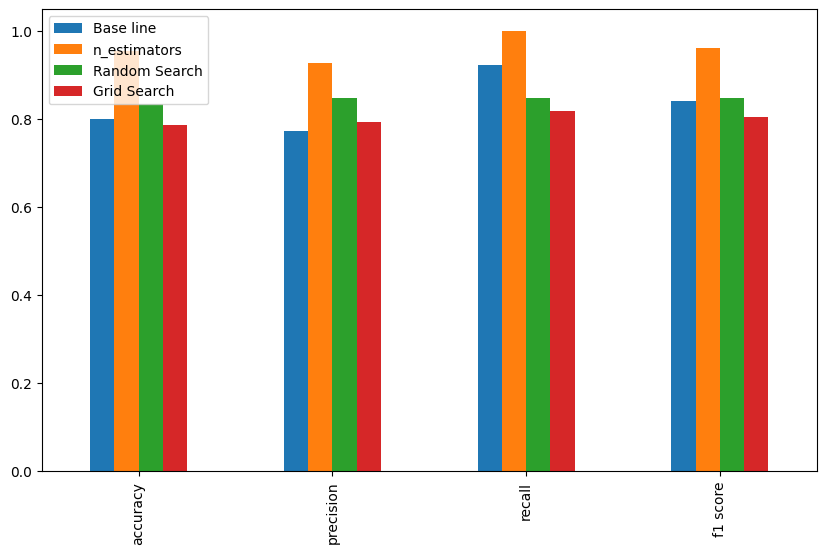

In [101]:
compare_metrics = pd.DataFrame({
    "Base line": baseline_metircs,
    "n_estimators" : clf_1_metircs,
    "Random Search": rs_metrics,
    "Grid Search": gs_metrics
})

compare_metrics.plot.bar(figsize=(10,6))